In [1]:
import matplotlib

# Force Matplotlib to use a known, installed sans‐serif
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
matplotlib.rcParams['font.family'] = 'sans-serif'

# (Optional) If you ever imported Chinese fonts before, you can clear Matplotlib’s font cache:
# from matplotlib import font_manager
# font_manager._rebuild()


Social scatter for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30


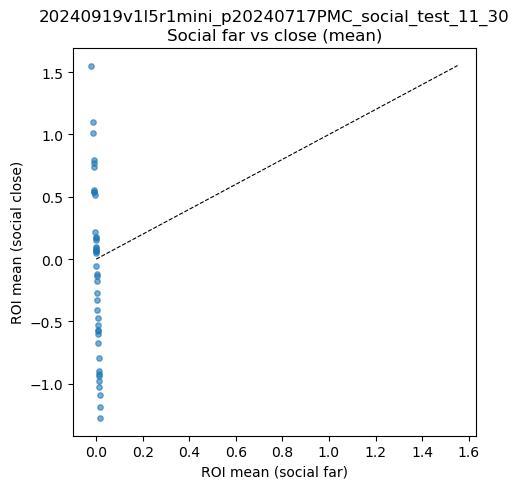

Social scatter for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04


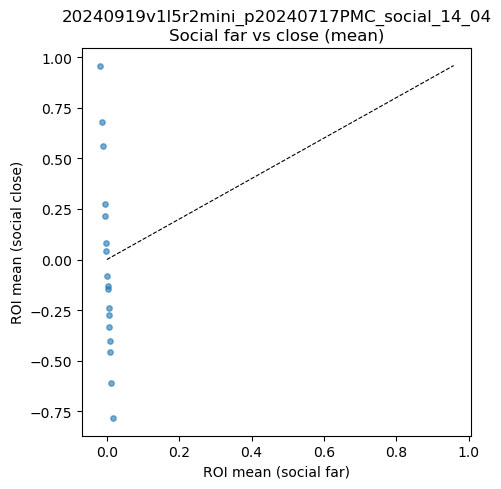

Social scatter for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29


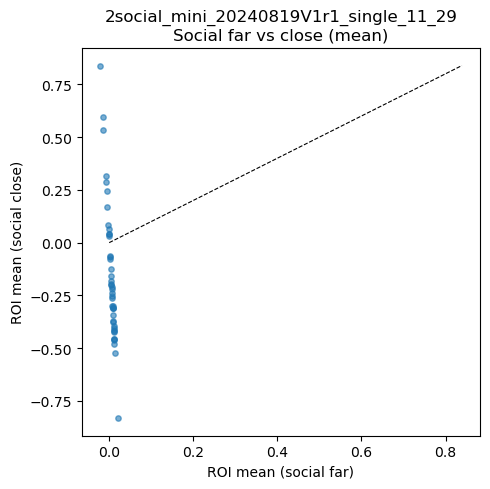

Social scatter for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48


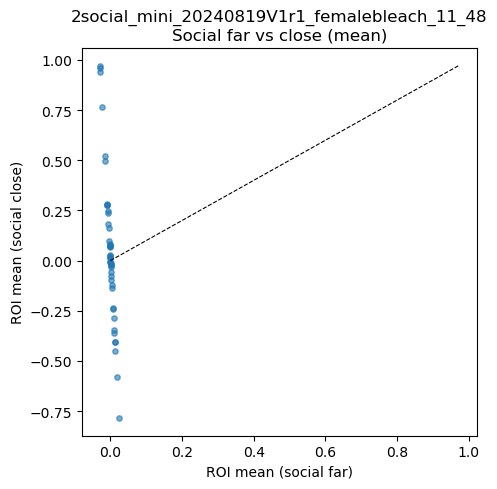

Social scatter for: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2


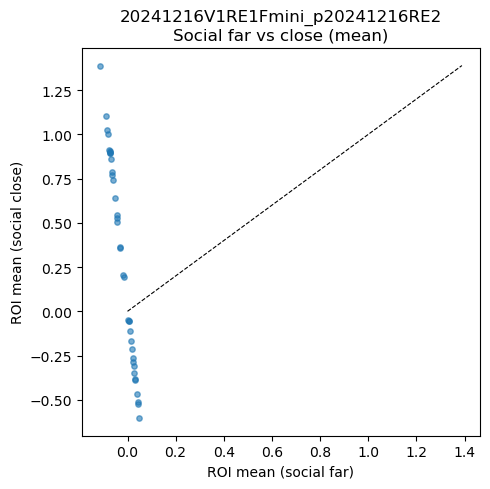

Social scatter for: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1


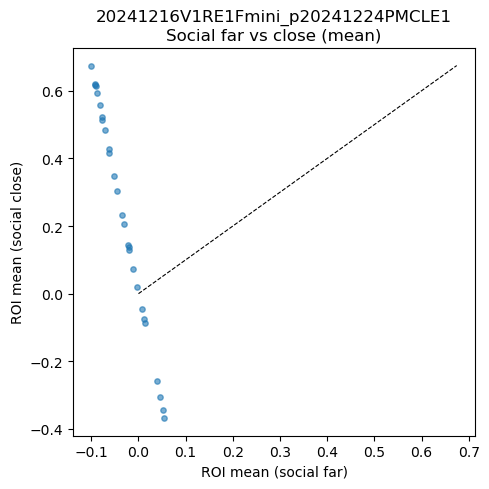


Single vs Social scatter:
 Single: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37
 Social: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29


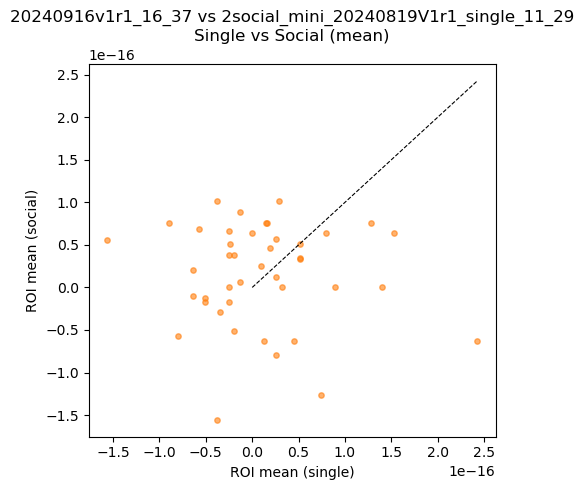


Done.


In [2]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions (unchanged)
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Build neuron-by-frame matrix (z-scored), return neuron names & matrix
# ----------------------------------------------------------------------------
def build_neuron_matrix(df, exclude_dict):
    """
    - Resets index if needed.
    - Excludes neurons listed in exclude_dict.
    - Filters out the bottom 5% of low-variance neurons.
    - Z-score normalizes each retained neuron (row).
    Returns:
      neuron_names: list of strings, e.g. ['dF_F_roi3', 'dF_F_roi5', ...]
      mat: numpy array of shape (n_kept_neurons, n_frames)
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    # Find all dF_F_roi columns
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    # Exclude specified
    keep_names = [c for c in all_names if int(c.split('_')[-1][3:]) not in excluded]
    if not keep_names:
        return [], np.zeros((0, len(df)))
    activity = df[keep_names].values.T   # shape: (n_neurons, n_frames)
    # Compute variance per neuron
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]     # (n_kept, n_frames)
    if filtered.size:
        normalized = zscore(filtered, axis=1, nan_policy='omit')
    else:
        normalized = filtered
    return kept_names, normalized

# ----------------------------------------------------------------------------
# 3a. Compute COM-distance for social sessions (unchanged)
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("At least two 'com' prefixes required for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

# ----------------------------------------------------------------------------
# 3b. Compute COM-speed for single sessions (unchanged)
# ----------------------------------------------------------------------------
def compute_com_speed(df_new):
    if not all(k in df_new.columns for k in ['com_x','com_y','com_z']):
        raise ValueError("Single session must contain 'com_x', 'com_y', 'com_z'.")
    x = df_new['com_x'].values
    y = df_new['com_y'].values
    z = df_new['com_z'].values
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])
    return np.sqrt(dx**2 + dy**2 + dz**2)

# ----------------------------------------------------------------------------
# 4a. Get per-ROI summary stats for a social session
# ----------------------------------------------------------------------------
def get_social_roi_stats(rec_path, exclude_dict, threshold=250.0, 
                         stat='mean'):
    """
    For a given social session:
      1. Load dataframe & build z-scored neuron matrix (n_kept, n_frames)
      2. Compute COM-distance array of length n_frames
      3. Split frames into 'close' (dist <= threshold) and 'far' (> threshold)
      4. For each neuron (row), compute summary stat ('mean' or '95th') on its activity during 'far' and 'close'
    Returns:
      roi_names: list of length n_kept
      stat_far: numpy array of length n_kept
      stat_close: numpy array of length n_kept
    """
    df = load_session_data(rec_path)
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    roi_names, mat = build_neuron_matrix(df, exclude_dict)    # (n_kept, n_frames)
    if mat.size == 0:
        return [], np.array([]), np.array([])
    # Compute COM-distance
    dist_raw = compute_com_distance_raw(df)
    close_mask = dist_raw <= threshold
    far_mask   = dist_raw > threshold
    # Summary per neuron
    if stat == 'mean':
        stat_far   = np.nanmean(mat[:, far_mask], axis=1)
        stat_close = np.nanmean(mat[:, close_mask], axis=1)
    elif stat == '95th':
        stat_far   = np.nanpercentile(mat[:, far_mask], 95, axis=1)
        stat_close = np.nanpercentile(mat[:, close_mask], 95, axis=1)
    else:
        raise ValueError("stat must be 'mean' or '95th'")
    return roi_names, stat_far, stat_close

# ----------------------------------------------------------------------------
# 4b. Get per-ROI summary stats for a single session
# ----------------------------------------------------------------------------
def get_single_roi_stats(rec_path, exclude_dict, stat='mean'):
    """
    For a given single session:
      1. Load dataframe & build z-scored neuron matrix (n_kept, n_frames)
      2. For each neuron, compute summary stat over all frames
    Returns:
      roi_names: list of length n_kept
      stat_all: numpy array of length n_kept
    """
    df = load_session_data(rec_path)
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    roi_names, mat = build_neuron_matrix(df, exclude_dict)
    if mat.size == 0:
        return [], np.array([])
    if stat == 'mean':
        stat_all = np.nanmean(mat, axis=1)
    elif stat == '95th':
        stat_all = np.nanpercentile(mat, 95, axis=1)
    else:
        raise ValueError("stat must be 'mean' or '95th'")
    return roi_names, stat_all

# ----------------------------------------------------------------------------
# 5a. Scatter: social far vs social close (per session)
# ----------------------------------------------------------------------------
def plot_social_far_vs_close(rec_path, exclude_dict, threshold=250.0, stat='mean'):
    roi_names, sf, sc = get_social_roi_stats(rec_path, exclude_dict, threshold, stat)
    if not roi_names:
        print(f"No valid ROIs for social scatter in {rec_path}")
        return
    plt.figure(figsize=(5, 5))
    plt.scatter(sf, sc, s=15, alpha=0.6)
    maxval = np.nanmax(np.concatenate([sf, sc])) if sf.size else 1
    plt.plot([0, maxval], [0, maxval], 'k--', linewidth=0.8)
    plt.xlabel(f"ROI {stat} (social far)")
    plt.ylabel(f"ROI {stat} (social close)")
    title = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{title}\nSocial far vs close ({stat})")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 5b. Scatter: single vs social (matching ROI names between two sessions)
# ----------------------------------------------------------------------------
def plot_single_vs_social(single_path, social_path, exclude_dict, stat='mean'):
    names_sgl, stats_sgl = get_single_roi_stats(single_path, exclude_dict, stat)
    names_soc, stats_soc = get_social_roi_stats(social_path, exclude_dict, stat=stat)[:2]
    # get_social_roi_stats returns (roi_names, stat_far, stat_close). Use combined social stat:
    # Here we take social mean across ALL social frames (close+far)
    # Instead, we recompute that global summary:
    _, mat_soc = build_neuron_matrix(load_session_data(social_path).reset_index(), exclude_dict)
    if mat_soc.size:
        if stat == 'mean':
            social_global = np.nanmean(mat_soc, axis=1)
        else:  # '95th'
            social_global = np.nanpercentile(mat_soc, 95, axis=1)
    else:
        social_global = np.array([])

    # Intersect ROI names
    set_sgl = set(names_sgl)
    set_soc = set(names_soc)
    common = sorted(list(set_sgl & set_soc))
    if not common:
        print("No matching ROI names between single and social sessions.")
        return

    idx_sgl = [names_sgl.index(r) for r in common]
    idx_soc = [names_soc.index(r) for r in common]

    vals_sgl = stats_sgl[idx_sgl]
    vals_soc = social_global[idx_soc]

    plt.figure(figsize=(5, 5))
    plt.scatter(vals_sgl, vals_soc, s=15, alpha=0.6, c='C1')
    maxval = np.nanmax(np.concatenate([vals_sgl, vals_soc])) if vals_sgl.size else 1
    plt.plot([0, maxval], [0, maxval], 'k--', linewidth=0.8)
    plt.xlabel(f"ROI {stat} (single)")
    plt.ylabel(f"ROI {stat} (social)")
    t1 = os.path.basename(os.path.normpath(single_path))
    t2 = os.path.basename(os.path.normpath(social_path))
    plt.title(f"{t1} vs {t2}\nSingle vs Social ({stat})")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 6. Example usage
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # Threshold for social far/close (in same units as COM distance)
    threshold = 250.0
    # Whether to use mean or the 95th percentile
    summary_stat = 'mean'    # or '95th'

    # ---- (A) Social far vs close scatter, per social session ----
    social_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    ]
    for soc_path in social_sessions:
        print(f"Social scatter for: {soc_path}")
        try:
            plot_social_far_vs_close(soc_path, exclude_mapping, threshold, summary_stat)
        except Exception as e:
            print(f"  Skipped {soc_path}: {e}")

    # ---- (B) Single vs Social scatter for a matching pair ----
    # Fill in one single session and one social session that share ROI names
    single_session = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37"
    matching_social = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29"
    print(f"\nSingle vs Social scatter:\n Single: {single_session}\n Social: {matching_social}")
    try:
        plot_single_vs_social(single_session, matching_social, exclude_mapping, summary_stat)
    except Exception as e:
        print(f"  Could not plot single vs social: {e}")

    print("\nDone.")


Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30


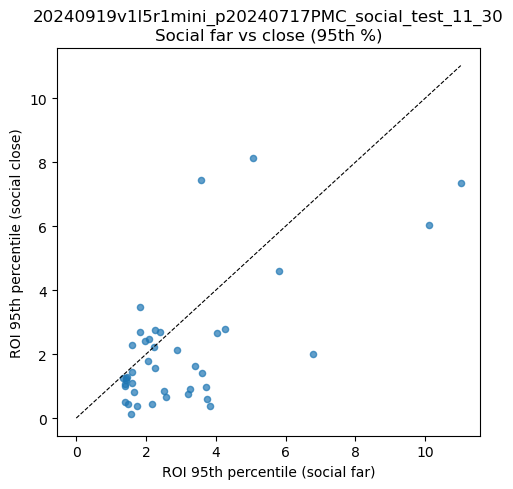

Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04


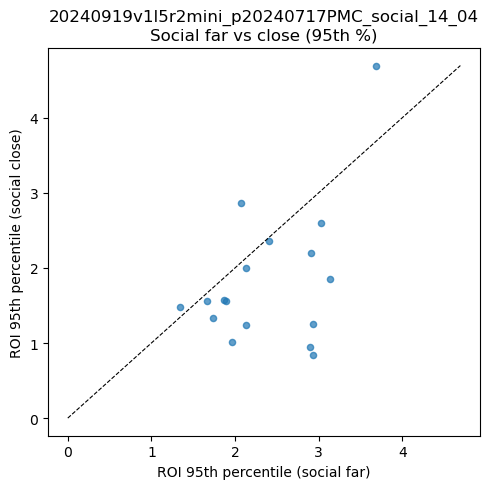

Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29


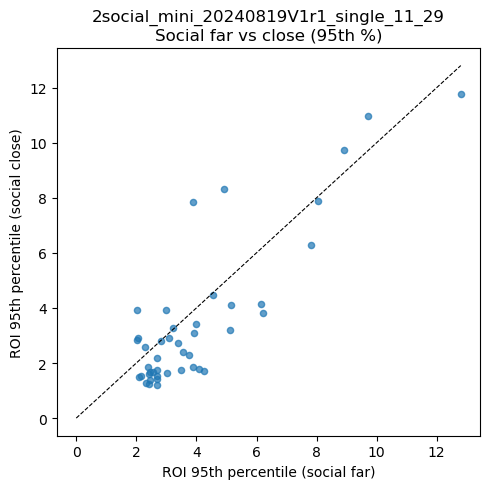

Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48


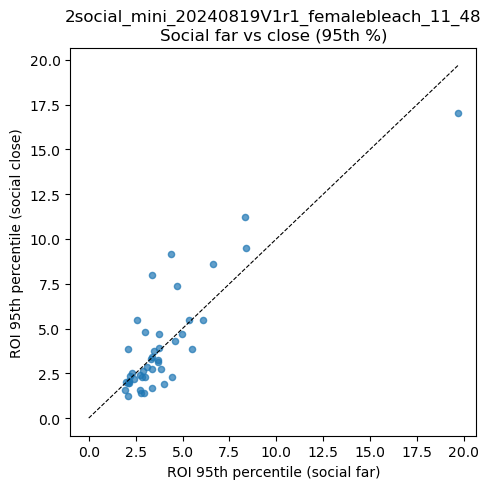

Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2


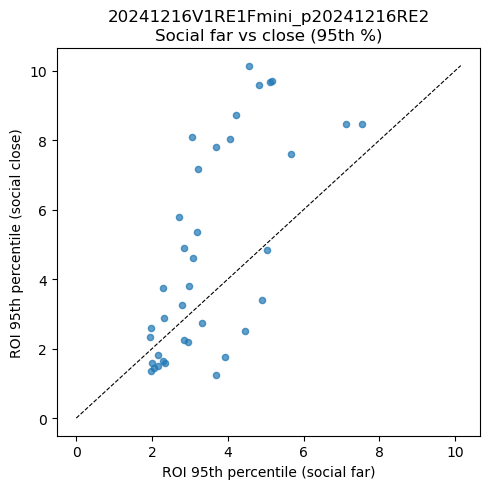

Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1


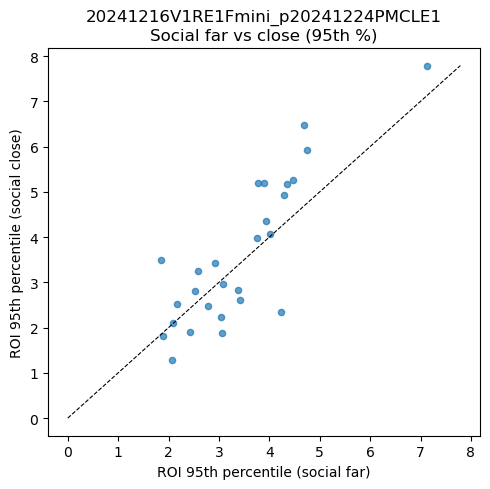

All done.


In [3]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加一些额外列。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Build neuron-by-frame matrix (raw dF/F), 排除低方差 & 排除名单
# ----------------------------------------------------------------------------
def build_neuron_matrix_raw(df, exclude_dict):
    """
    - 如果 df 的 index 名是 'timestamp_ms_mini'，先 reset_index()
    - 找到所有 dF_F_roi 列，排除 exclude_dict 指定的那些 ROI 索引
    - 计算每个 ROI 的方差，将底部 5% 的 ROI 排掉
    - 返回：kept_names (list[str]) 和 raw_matrix (numpy.ndarray, shape=(n_kept, n_frames))
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    # 找到所有 dF_F_roi 列
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    # 排除那些索引在 excluded 里的 ROI
    # 每个列名格式 "dF_F_roiXX"，取最后数字部分：
    keep_names = []
    for c in all_names:
        try:
            idx = int(c.split('_')[-1][3:])  # "roiXX" -> XX
        except:
            continue
        if idx not in excluded:
            keep_names.append(c)
    if not keep_names:
        # 没有 ROI 留下，则返回空矩阵
        return [], np.zeros((0, len(df)))
    # 构建 (n_all_neurons, n_frames) 矩阵
    activity = df[keep_names].values.T   # 转置后 (n_neurons, n_frames)
    # 计算每个神经元（行）的方差
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]     # (n_kept, n_frames)
    return kept_names, filtered

# ----------------------------------------------------------------------------
# 3. 计算 social session 中每个 ROI 在 far/close 的 summary statistic
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df):
    """
    查找 df 中所有以 'com<idx>_x' 开头的列，取前两个 prefix（p1, p2），
    然后计算它们对应的 (x, y, z) 之间的欧氏距离，得到长度为 n_frames 的距离数组。
    """
    prefixes = sorted({col.split('_')[0] for col in df.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("At least two 'com' prefixes required for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df[f'{p1}_x'] - df[f'{p2}_x']
    dy = df[f'{p1}_y'] - df[f'{p2}_y']
    dz = df[f'{p1}_z'] - df[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

def get_social_roi_stats_raw(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    对一个 social session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 计算每一帧 COM 距离 => 得到距离数组 dist_raw
      3. 根据 threshold，分类成 far_mask (dist > threshold) 和 close_mask (dist <= threshold)
      4. 对每个 ROI（行），计算 raw dF/F 在 far_mask 区间的第 pct 百分位数以及 close_mask 区间的 pct 百分位数
    返回：
      roi_names: list of ROI 列名
      stat_far: numpy array, length = n_kept
      stat_close: numpy array, length = n_kept
    """
    df = load_session_data(rec_path)
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)  # (n_kept, n_frames)
    if mat_raw.size == 0:
        return [], np.array([]), np.array([])
    dist_raw = compute_com_distance_raw(df)
    close_mask = dist_raw <= threshold
    far_mask   = dist_raw > threshold
    # 直接对 raw dF/F 求第 pct 百分位数
    stat_far   = np.nanpercentile(mat_raw[:, far_mask], pct, axis=1)
    stat_close = np.nanpercentile(mat_raw[:, close_mask], pct, axis=1)
    return roi_names, stat_far, stat_close

# ----------------------------------------------------------------------------
# 4. 简单绘制 scatter: social far vs social close
# ----------------------------------------------------------------------------
def plot_social_far_vs_close(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    画一张 scatter：每个 ROI 的 (far_pct, close_pct)，横坐标是 social far 的 pct 值，纵坐标是 social close 的 pct 值
    """
    roi_names, sf, sc = get_social_roi_stats_raw(rec_path, exclude_dict, threshold, pct)
    if len(roi_names) == 0:
        print(f"No ROIs available for session: {rec_path}")
        return
    plt.figure(figsize=(5, 5))
    plt.scatter(sf, sc, s=20, alpha=0.7)
    maxval = np.nanmax(np.concatenate([sf, sc])) if sf.size else 1
    plt.plot([0, maxval], [0, maxval], 'k--', linewidth=0.8)
    plt.xlabel(f"ROI {pct}th percentile (social far)")
    plt.ylabel(f"ROI {pct}th percentile (social close)")
    title = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{title}\nSocial far vs close ({pct}th %)")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 5. Example execution：对多条 social session 画散点图
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # ---------- 配置区域 ----------
    threshold = 250.0   # COM 距离阈值（单位同 COM 坐标单位）
    pct       = 95      # 使用第 95 百分位数，也可改成 50（即 median）或 100（max）等

    # 定义你要绘制 scatter 的所有 social session 路径列表
    social_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    ]

    for rec_path in social_sessions:
        print(f"Plotting far vs close for: {rec_path}")
        try:
            plot_social_far_vs_close(rec_path, exclude_mapping, threshold, pct)
        except Exception as e:
            print(f"  Skipped {rec_path} due to error: {e}")

    print("All done.")


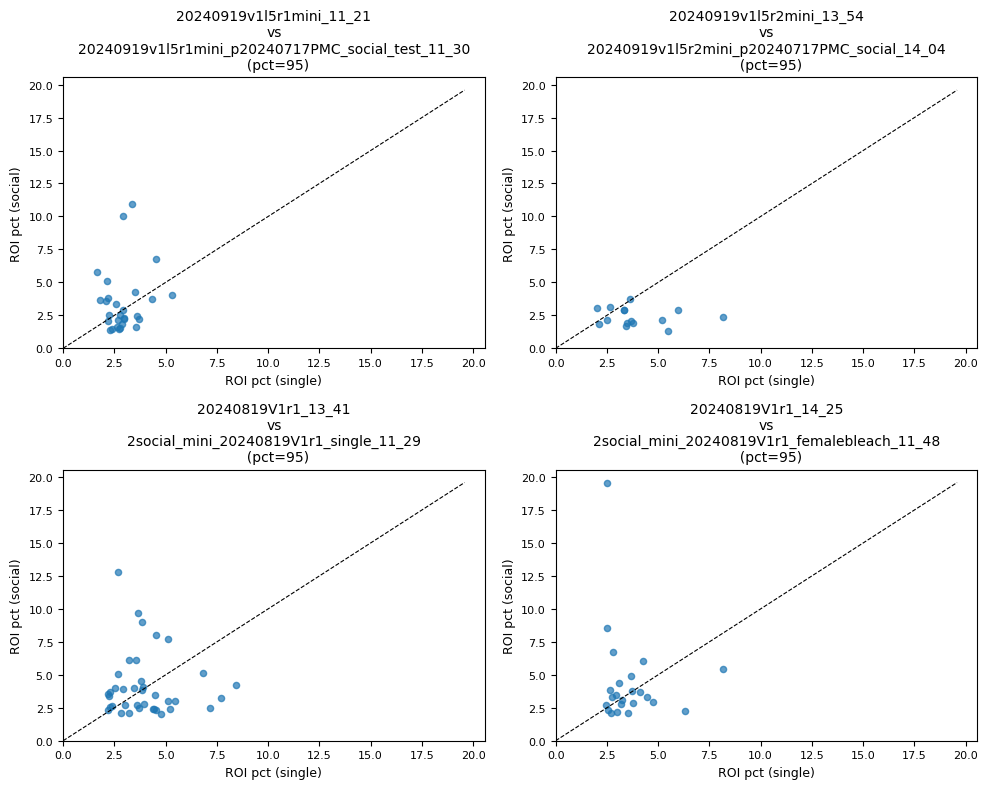

Done.


In [5]:
import os
import glob
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加额外列。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Build neuron-by-frame matrix (raw dF/F), 排除低方差 & 排除名单
# ----------------------------------------------------------------------------
def build_neuron_matrix_raw(df, exclude_dict):
    """
    - 如果 df 的 index 名是 'timestamp_ms_mini'，先 reset_index()
    - 找到所有 dF_F_roi 列，排除 exclude_dict 指定的那些 ROI 索引
    - 计算每个 ROI 的方差，将底部 5% 的 ROI 排掉
    - 返回：kept_names (list[str]) 和 raw_matrix (numpy.ndarray, shape=(n_kept, n_frames))
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    # 找到所有 dF_F_roi 列
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    # 排除那些索引在 excluded 里的 ROI
    keep_names = []
    for c in all_names:
        try:
            idx = int(c.split('_')[-1][3:])  # "roiXX" -> XX
        except:
            continue
        if idx not in excluded:
            keep_names.append(c)
    if not keep_names:
        return [], np.zeros((0, len(df)))
    # 构建 (n_all_neurons, n_frames) 矩阵
    activity = df[keep_names].values.T   # 转置后 (n_neurons, n_frames)
    # 计算每个神经元（行）的方差
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]     # (n_kept, n_frames)
    return kept_names, filtered

# ----------------------------------------------------------------------------
# 3a. 获取 single session 的 summary statistic（95th percentile）
# ----------------------------------------------------------------------------
def get_single_roi_stats_raw(rec_path, exclude_dict, pct=95):
    """
    对一个 single session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 对每个 ROI（行），计算 raw dF/F 在全时段的第 pct 百分位数
    返回：
      roi_names: list of ROI 列名
      stat_all: numpy array, length = n_kept
    """
    df = load_session_data(rec_path)
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([])
    stat_all = np.nanpercentile(mat_raw, pct, axis=1)
    return roi_names, stat_all

# ----------------------------------------------------------------------------
# 3b. 获取 social session 的全时段 summary statistic（95th percentile）
# ----------------------------------------------------------------------------
def get_social_roi_stats_raw(rec_path, exclude_dict, pct=95):
    """
    对一个 social session（不区分 far/close，只取全时段）：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 对每个 ROI（行），计算 raw dF/F 在全时段的第 pct 百分位数
    返回：
      roi_names: list of ROI 列名
      stat_all: numpy array, length = n_kept
    """
    df = load_session_data(rec_path)
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([])
    stat_all = np.nanpercentile(mat_raw, pct, axis=1)
    return roi_names, stat_all

# ----------------------------------------------------------------------------
# 4. 计算一对 single vs social 的 scatter 数据
# ----------------------------------------------------------------------------
def compute_single_vs_social_pair(single_path, social_path, exclude_dict, pct=95):
    """
    对一对 single session 和 social session：
      1. 获取 single session 里每个 ROI 的 pct 百分位值 (stat_sgl)
      2. 获取 social session 里每个 ROI 的 pct 百分位值 (stat_soc)
      3. 找到两者的公共 roi_names，返回这些公共 ROI 在两个 session 下的对齐数值
    返回：
      common_names:  list[str]，公共 ROI 名称
      vals_single:   numpy array, shape=(n_common,)
      vals_social:   numpy array, shape=(n_common,)
    """
    names_sgl, stats_sgl = get_single_roi_stats_raw(single_path, exclude_dict, pct)
    names_soc, stats_soc = get_social_roi_stats_raw(social_path, exclude_dict, pct)
    set_sgl = set(names_sgl)
    set_soc = set(names_soc)
    common = sorted(list(set_sgl & set_soc))
    if not common:
        return [], np.array([]), np.array([])
    idx_sgl = [names_sgl.index(r) for r in common]
    idx_soc = [names_soc.index(r) for r in common]
    vals_sgl = stats_sgl[idx_sgl]
    vals_soc = stats_soc[idx_soc]
    return common, vals_sgl, vals_soc

# ----------------------------------------------------------------------------
# 5. 绘制多对子 session 的 scatter（放在同一个 figure 里）
# ----------------------------------------------------------------------------
def plot_multiple_single_vs_social(pairs, exclude_dict, pct=95):
    """
    pairs: list of tuple (single_path, social_path)
    将所有 pair 放到同一个大 figure，按网格排列子图，每个子图是一个 pair 的 scatter。
    """
    n_pairs = len(pairs)
    if n_pairs == 0:
        print("No session pairs provided.")
        return

    # 先计算所有 pair 的数据，收集所有 scatter 坐标以便统一坐标轴
    all_scatter = []
    global_max = 0.0
    for single_path, social_path in pairs:
        names, vs, vo = compute_single_vs_social_pair(single_path, social_path, exclude_dict, pct)
        if len(names) == 0:
            print(f"Pair skipped (no common ROI):\n  single: {single_path}\n  social: {social_path}\n")
            all_scatter.append((None, None, None))
            continue
        all_scatter.append((names, vs, vo))
        cur_max = np.nanmax(np.concatenate([vs, vo]))
        if cur_max > global_max:
            global_max = cur_max

    # 确定画布布局：2 列为宜，行数 ceil(n_pairs/2)
    n_cols = 2
    n_rows = math.ceil(n_pairs / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, ((single_path, social_path), scatter_data) in enumerate(zip(pairs, all_scatter)):
        ax = axes[i]
        names, vs, vo = scatter_data
        if names is None:
            ax.axis('off')
            continue

        ax.scatter(vs, vo, s=20, alpha=0.7)
        ax.plot([0, global_max], [0, global_max], 'k--', linewidth=0.8)
        ax.set_xlim(0, global_max * 1.05)
        ax.set_ylim(0, global_max * 1.05)

        s_title = os.path.basename(os.path.normpath(single_path))
        t_title = os.path.basename(os.path.normpath(social_path))
        ax.set_title(f"{s_title}\nvs\n{t_title}\n  (pct={pct})", fontsize=10)
        ax.set_xlabel("ROI pct (single)", fontsize=9)
        ax.set_ylabel("ROI pct (social)", fontsize=9)
        ax.tick_params(axis='both', which='major', labelsize=8)

    # 如果子图比 pairs 多，隐藏多余的
    for j in range(n_pairs, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 6. Example usage
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    pct = 95   # 95th 百分位，也可改成 50, 100 等

    # 在这里填写你的一组 single vs social 的路径对（可以多对）
    pairs = [
        (
            "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
            "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30"
        ),
        (
            "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
            "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04"
        ),
        (
            "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
            "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29"
        ),
        (
            "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
            "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48"
        ),
        # 你可以继续添加更多 (single_path, social_path) 对
    ]

    plot_multiple_single_vs_social(pairs, exclude_mapping, pct)

    print("Done.")


Collected 211 social-far points and 211 social-close points.


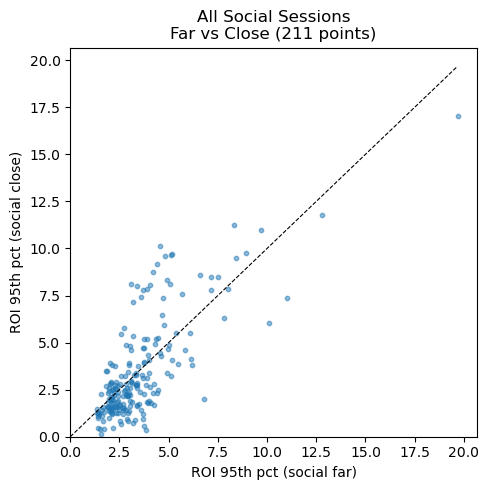

Collected 292 single-session ROI points.


/tmp/ipykernel_1260611/1253654324.py:230: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


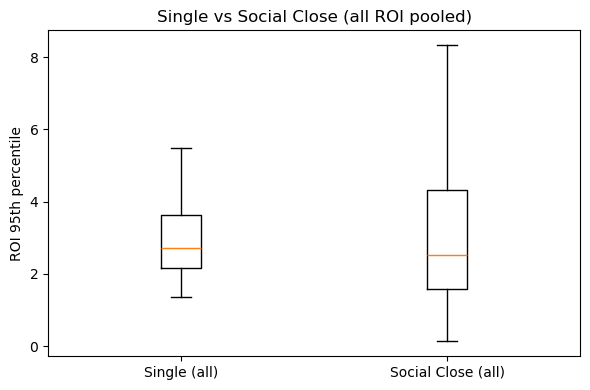

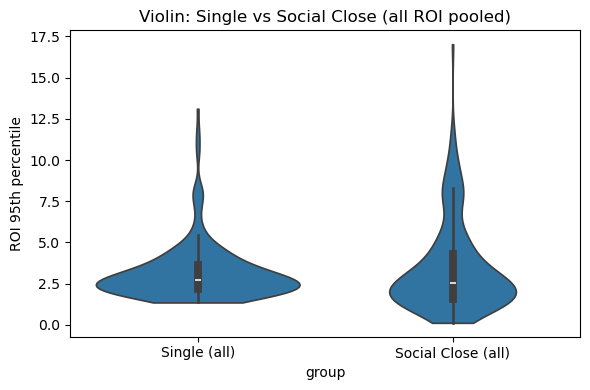

Analysis complete.


In [6]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加 session_path。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    df['session_path'] = rec_path
    return df

# ----------------------------------------------------------------------------
# 2. Build neuron-by-frame matrix (raw dF/F), 排除低方差 & 排除名单
# ----------------------------------------------------------------------------
def build_neuron_matrix_raw(df, exclude_dict):
    """
    - 如果 df 的 index 名是 'timestamp_ms_mini'，先 reset_index()
    - 找到所有 dF_F_roi 列，排除 exclude_dict 指定的那些 ROI 索引
    - 计算每个 ROI 的方差，将底部 5% 的 ROI 排掉
    - 返回：kept_names (list[str]) 和 raw_matrix (numpy.ndarray, shape=(n_kept, n_frames))
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    # 找到所有 dF_F_roi 列
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    # 排除那些索引在 excluded 里的 ROI
    keep_names = []
    for c in all_names:
        try:
            idx = int(c.split('_')[-1][3:])  # "roiXX" -> XX
        except:
            continue
        if idx not in excluded:
            keep_names.append(c)
    if not keep_names:
        return [], np.zeros((0, len(df)))
    # 构建 (n_all_neurons, n_frames) 矩阵
    activity = df[keep_names].values.T   # 转置后 (n_neurons, n_frames)
    # 计算每个神经元（行）的方差
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]     # (n_kept, n_frames)
    return kept_names, filtered

# ----------------------------------------------------------------------------
# 3a. 获取 social session 中每个 ROI 在 far/close 片段的 95th percentile
# ----------------------------------------------------------------------------
def get_social_far_close_stats(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    对一个 social session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 计算 COM 距离：
         - 找到所有以 'com<idx>_x' 开头的列，取前两前缀 (p1, p2)
         - 计算每帧距离 dist = sqrt((p1_x-p2_x)^2 + (p1_y-p2_y)^2 + (p1_z-p2_z)^2)
      3. 根据 threshold 分类成 far_mask (dist > threshold) 和 close_mask (dist <= threshold)
      4. 对每个 ROI（行），分别计算 raw dF/F 在 far 和 close 片段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_far:   numpy array of shape (n_kept,)
      stat_close: numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([]), np.array([])

    # 计算 COM 距离
    prefixes = sorted({col.split('_')[0] for col in df.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError(f"No sufficient 'com' prefixes in {rec_path}")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df[f'{p1}_x'] - df[f'{p2}_x']
    dy = df[f'{p1}_y'] - df[f'{p2}_y']
    dz = df[f'{p1}_z'] - df[f'{p2}_z']
    dist = np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

    close_mask = dist <= threshold
    far_mask   = dist > threshold
    # 如果某一段没有任何帧，np.nanpercentile 会报错，因此要提前检查
    if not np.any(close_mask):
        stat_close = np.zeros(len(roi_names)) + np.nan
    else:
        stat_close = np.nanpercentile(mat_raw[:, close_mask], pct, axis=1)
    if not np.any(far_mask):
        stat_far = np.zeros(len(roi_names)) + np.nan
    else:
        stat_far = np.nanpercentile(mat_raw[:, far_mask], pct, axis=1)

    return roi_names, stat_far, stat_close

# ----------------------------------------------------------------------------
# 3b. 获取 single session 中每个 ROI 在全时段的 95th percentile
# ----------------------------------------------------------------------------
def get_single_stats(rec_path, exclude_dict, pct=95):
    """
    对一个 single session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 对每个 ROI（行），计算 raw dF/F 在全时段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_all:   numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([])
    stat_all = np.nanpercentile(mat_raw, pct, axis=1)
    return roi_names, stat_all

# ----------------------------------------------------------------------------
# 4. 收集多个 social session 的 far/close 数据 & 单独收集所有 single session 的 stat
# ----------------------------------------------------------------------------
def aggregate_social_far_close(social_sessions, exclude_dict, threshold=250.0, pct=95):
    """
    对一组 social_sessions，循环调用 get_social_far_close_stats，
    把所有 ROI 的 far_pct 和 close_pct 全部合并到两个大列表里：
      all_far_stats  = [stat_far_i for each ROI i in each session]
      all_close_stats= [stat_close_i for each ROI i in each session]
    返回：
      np.array(all_far_stats), np.array(all_close_stats)
    """
    all_far = []
    all_close = []

    for rec_path in social_sessions:
        try:
            roi_names, stat_far, stat_close = get_social_far_close_stats(rec_path, exclude_dict, threshold, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        # 有些 session 里可能 stat_far/stat_close 里有 nan，直接过滤掉
        valid_idx = ~np.isnan(stat_far) & ~np.isnan(stat_close)
        all_far.extend(stat_far[valid_idx].tolist())
        all_close.extend(stat_close[valid_idx].tolist())

    return np.array(all_far), np.array(all_close)

def aggregate_single_stats(single_sessions, exclude_dict, pct=95):
    """
    对一组 single_sessions，循环调用 get_single_stats，
    把所有 ROI 的 pct 值合并到一个大列表里： all_single_stats
    返回：
      np.array(all_single_stats)
    """
    all_single = []

    for rec_path in single_sessions:
        try:
            roi_names, stat_all = get_single_stats(rec_path, exclude_dict, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        # 过滤掉 nan
        valid_idx = ~np.isnan(stat_all)
        all_single.extend(stat_all[valid_idx].tolist())

    return np.array(all_single)

# ----------------------------------------------------------------------------
# 5. 可视化——(1) 全部 social far vs close 的散点；(2) Single vs Social Close 的箱线或小提琴
# ----------------------------------------------------------------------------
def plot_social_far_vs_close_scatter(all_far, all_close):
    """
    画一张 scatter：横轴 = social far，纵轴 = social close，点来自所有 social sessions 的所有 ROI
    """
    if all_far.size == 0 or all_close.size == 0:
        print("No social far/close data to plot.")
        return

    global_max = np.nanmax(np.concatenate([all_far, all_close]))
    plt.figure(figsize=(5, 5))
    plt.scatter(all_far, all_close, s=10, alpha=0.5)
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (social far)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"All Social Sessions\nFar vs Close ({len(all_far)} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_single_vs_social_close_boxplot(all_single, all_close):
    """
    用箱线图或小提琴图比较两个分布：
      - all_single:   所有 single sessions 的 ROI 95th pct
      - all_close:    所有 social close 的 ROI 95th pct
    """
    data = [all_single, all_close]
    labels = ['Single (all)', 'Social Close (all)']

    # 箱线图
    plt.figure(figsize=(6, 4))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.ylabel("ROI 95th percentile")
    plt.title("Single vs Social Close (all ROI pooled)")
    plt.tight_layout()
    plt.show()

    # 小提琴图
    try:
        import seaborn as sns
        df_v = pd.DataFrame({
            'pct': np.concatenate(data),
            'group': np.repeat(labels, [len(all_single), len(all_close)])
        })
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pct', data=df_v, cut=0)
        plt.title("Violin: Single vs Social Close (all ROI pooled)")
        plt.ylabel("ROI 95th percentile")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

# ----------------------------------------------------------------------------
# 6. 示例执行
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # ---------- 用户配置 ----------
    threshold = 250.0   # COM 距离阈值
    pct       = 95      # 使用第 95 百分位数，也可改为 50 或 100

    # social sessions 列表（示例路径）
    social_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    ]

    # single sessions 列表（示例路径）
    single_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
        # 根据需要继续添加
    ]

    # ------------ (A) 聚合所有 social 的 far vs close -------------
    all_far, all_close = aggregate_social_far_close(social_sessions, exclude_mapping, threshold, pct)
    print(f"Collected {len(all_far)} social-far points and {len(all_close)} social-close points.")

    # 画出 scatter: social far vs close (聚合所有 session)
    plot_social_far_vs_close_scatter(all_far, all_close)

    # ------------ (B) 聚合所有 single vs 所有 social-close -------------
    all_single = aggregate_single_stats(single_sessions, exclude_mapping, pct)
    print(f"Collected {len(all_single)} single-session ROI points.")

    # 画出 boxplot/violin: single vs social-close（聚合所有ROI）
    plot_single_vs_social_close_boxplot(all_single, all_close)

    print("Analysis complete.")


Collected 211 social-far points and 211 social-close points.


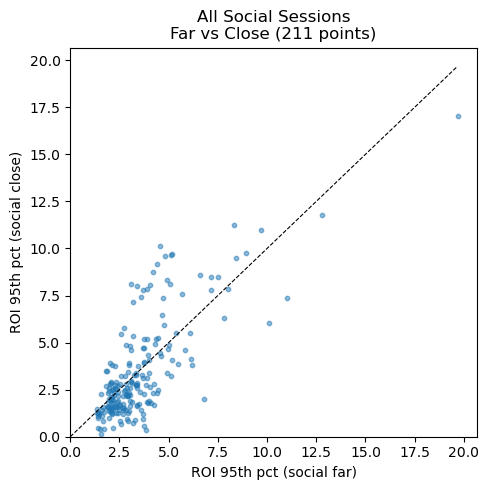

Collected 292 single-session ROI points.


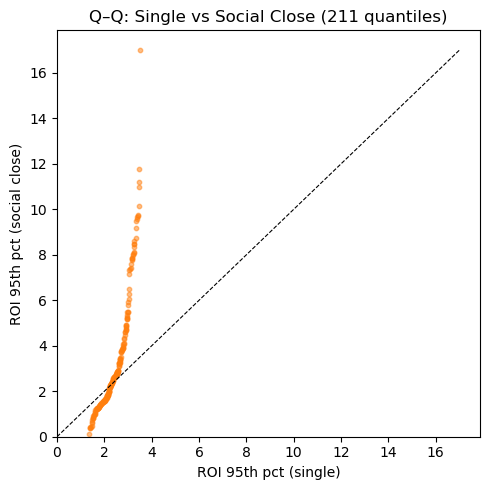

Done.


In [8]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加 session_path。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    df['session_path'] = rec_path
    return df

# ----------------------------------------------------------------------------
# 2. Build neuron-by-frame matrix (raw dF/F), 排除低方差 & 排除名单
# ----------------------------------------------------------------------------
def build_neuron_matrix_raw(df, exclude_dict):
    """
    - 如果 df 的 index 名是 'timestamp_ms_mini'，先 reset_index()
    - 找到所有 dF_F_roi 列，排除 exclude_dict 指定的那些 ROI 索引
    - 计算每个 ROI 的方差，将底部 5% 的 ROI 排掉
    - 返回：kept_names (list[str]) 和 raw_matrix (numpy.ndarray, shape=(n_kept, n_frames))
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    # 找到所有 dF_F_roi 列
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    # 排除那些索引在 excluded 里的 ROI
    keep_names = []
    for c in all_names:
        try:
            idx = int(c.split('_')[-1][3:])  # "roiXX" -> XX
        except:
            continue
        if idx not in excluded:
            keep_names.append(c)
    if not keep_names:
        return [], np.zeros((0, len(df)))
    # 构建 (n_all_neurons, n_frames) 矩阵
    activity = df[keep_names].values.T   # 转置后 (n_neurons, n_frames)
    # 计算每个神经元（行）的方差
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]     # (n_kept, n_frames)
    return kept_names, filtered

# ----------------------------------------------------------------------------
# 3a. 获取 social session 中每个 ROI 在 far/close 片段的 95th percentile
# ----------------------------------------------------------------------------
def get_social_far_close_stats(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    对一个 social session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 计算 COM 距离：
         - 找到所有以 'com<idx>_x' 开头的列，取前两个前缀 (p1, p2)
         - 计算每帧距离 dist = sqrt((p1_x-p2_x)^2 + (p1_y-p2_y)^2 + (p1_z-p2_z)^2)
      3. 根据 threshold 分类成 far_mask (dist > threshold) 和 close_mask (dist <= threshold)
      4. 对每个 ROI（行），分别计算 raw dF/F 在 far 和 close 片段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_far:   numpy array of shape (n_kept,)
      stat_close: numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([]), np.array([])

    # 计算 COM 距离
    prefixes = sorted({col.split('_')[0] for col in df.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError(f"No sufficient 'com' prefixes in {rec_path}")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df[f'{p1}_x'] - df[f'{p2}_x']
    dy = df[f'{p1}_y'] - df[f'{p2}_y']
    dz = df[f'{p1}_z'] - df[f'{p2}_z']
    dist = np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

    close_mask = dist <= threshold
    far_mask   = dist > threshold
    # 如果某一段没有任何帧，np.nanpercentile 会报错，因此要提前检查
    if not np.any(close_mask):
        stat_close = np.zeros(len(roi_names)) + np.nan
    else:
        stat_close = np.nanpercentile(mat_raw[:, close_mask], pct, axis=1)
    if not np.any(far_mask):
        stat_far = np.zeros(len(roi_names)) + np.nan
    else:
        stat_far = np.nanpercentile(mat_raw[:, far_mask], pct, axis=1)

    return roi_names, stat_far, stat_close

# ----------------------------------------------------------------------------
# 3b. 获取 single session 中每个 ROI 在全时段的 95th percentile
# ----------------------------------------------------------------------------
def get_single_stats(rec_path, exclude_dict, pct=95):
    """
    对一个 single session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 对每个 ROI（行），计算 raw dF/F 在全时段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_all:   numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([])
    stat_all = np.nanpercentile(mat_raw, pct, axis=1)
    return roi_names, stat_all

# ----------------------------------------------------------------------------
# 4a. 聚合所有 social session 的 far & close 数据
# ----------------------------------------------------------------------------
def aggregate_social_far_close(social_sessions, exclude_dict, threshold=250.0, pct=95):
    """
    对一组 social_sessions，循环调用 get_social_far_close_stats，
    把每个 ROI 的 far_pct 和 close_pct 都添加到 all_far 和 all_close 列表里。
    返回：
      np.array(all_far), np.array(all_close)
    """
    all_far = []
    all_close = []

    for rec_path in social_sessions:
        try:
            _, stat_far, stat_close = get_social_far_close_stats(rec_path, exclude_dict, threshold, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_far) & ~np.isnan(stat_close)
        all_far.extend(stat_far[valid_idx].tolist())
        all_close.extend(stat_close[valid_idx].tolist())

    return np.array(all_far), np.array(all_close)

# ----------------------------------------------------------------------------
# 4b. 聚合所有 single session 的全时段 95th 数据
# ----------------------------------------------------------------------------
def aggregate_single_stats(single_sessions, exclude_dict, pct=95):
    """
    对一组 single_sessions，循环调用 get_single_stats，
    把每个 ROI 的 pct 值添加到 all_single 列表里。
    返回：
      np.array(all_single)
    """
    all_single = []

    for rec_path in single_sessions:
        try:
            _, stat_all = get_single_stats(rec_path, exclude_dict, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_all)
        all_single.extend(stat_all[valid_idx].tolist())

    return np.array(all_single)

# ----------------------------------------------------------------------------
# 5. 可视化
#    (A) Social Far vs Social Close 散点图 (聚合所有 session)
#    (B) Single vs Social Close Q–Q 样式散点图 (95th percentile)
# ----------------------------------------------------------------------------
def plot_social_far_close_scatter(all_far, all_close):
    """
    画一张 scatter：横轴 = social far (95th)，纵轴 = social close (95th)。
    点来自所有 social session 的所有 ROI。
    """
    if all_far.size == 0 or all_close.size == 0:
        print("No social far/close data to plot.")
        return

    global_max = np.nanmax(np.concatenate([all_far, all_close]))
    plt.figure(figsize=(5, 5))
    plt.scatter(all_far, all_close, s=10, alpha=0.5)
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (social far)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"All Social Sessions\nFar vs Close ({len(all_far)} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_single_vs_social_close_qq(all_single, all_close):
    """
    用 Q–Q 样式的方法对比两个分布：
      - all_single: 所有 single sessions 的 ROI 95th pct
      - all_close:  所有 social close 的 ROI 95th pct
    方法：排序后按 index 一一对应，绘制 scatter。
    """
    if all_single.size == 0 or all_close.size == 0:
        print("No data for Single vs Social Close Q–Q plot.")
        return

    # 对两个数组分别排序
    sorted_single = np.sort(all_single)
    sorted_close  = np.sort(all_close)
    # 取长度较小的那部分
    n = min(len(sorted_single), len(sorted_close))
    x = sorted_single[:n]
    y = sorted_close[:n]

    global_max = max(x.max(), y.max())
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C1')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (single)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"Q–Q: Single vs Social Close ({n} quantiles)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 6. 示例执行
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    threshold = 250.0   # COM 距离阈值
    pct       = 95      # 使用第 95 百分位数

    # 社交 sessions 列表（示例路径）
    social_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    ]

    # 单人 sessions 列表（示例路径）
    single_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
        # 根据需要继续添加更多 single paths
    ]

    # ---- 聚合 social far vs social close 数据 ----
    all_far, all_close = aggregate_social_far_close(social_sessions, exclude_mapping, threshold, pct)
    print(f"Collected {len(all_far)} social-far points and {len(all_close)} social-close points.")
    plot_social_far_close_scatter(all_far, all_close)

    # ---- 聚合 single 全时段 vs social close ----
    all_single = aggregate_single_stats(single_sessions, exclude_mapping, pct)
    print(f"Collected {len(all_single)} single-session ROI points.")
    plot_single_vs_social_close_qq(all_single, all_close)

    print("Done.")


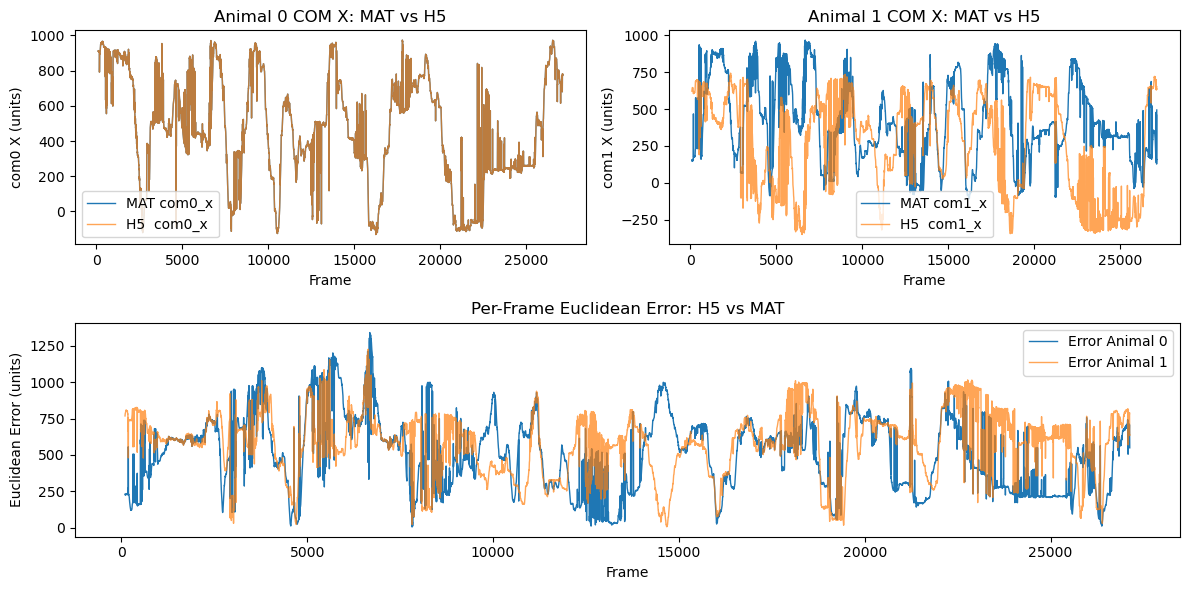

已将对比结果保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/com_mat_vs_h5_comparison.csv


In [10]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_com_mat_vs_h5(
    base_folder: str,
    com_folder_name: str,
    h5_path: str,
    animal_indices=(0, 1),
    plot_results: bool = True
):
    """
    对比 .mat 文件中的 COM (两只动物) 与 HDF5 中预测的 COM。

    参数
    ----
    base_folder : str
        会话的根目录，包含 "{com_folder_name}/com3d0.mat"。
    com_folder_name : str
        相对于 base_folder 的 COM 文件子文件夹名，例如 "COM/predict00"。
    h5_path : str
        HDF5 文件（包含 DataFrame）的完整路径。
        DataFrame 必须包含列：
        - 'camera_frame_sixcam'：对应帧索引
        - 两只动物各自的 COM 坐标列，例如 "com3d0_x", "com3d0_y", "com3d0_z"，
          以及 "com3d1_x", "com3d1_y", "com3d1_z"。
    animal_indices : tuple(int, int), 默认 (0, 1)
        指定取 com3dXi.mat 中的哪两只动物，通常是 [0, 1]。
    plot_results : bool, 默认 True
        是否绘制对比结果图。

    返回
    ----
    pd.DataFrame
        包含以下列：
        - 'frame'：帧索引
        - 'mat_com0_x', 'mat_com0_y', 'mat_com0_z'：来自 .mat 的动物 0 COM
        - 'mat_com1_x', 'mat_com1_y', 'mat_com1_z'：来自 .mat 的动物 1 COM
        - 'h5_com0_x',  'h5_com0_y',  'h5_com0_z'：来自 HDF5 的动物 0 COM
        - 'h5_com1_x',  'h5_com1_y',  'h5_com1_z'：来自 HDF5 的动物 1 COM
        - 'err0', 'err1'：两只动物在每帧上的欧式坐标误差（HDF5 vs MAT）
    """

    # 1. 加载 .mat 中的 COM 数据
    mat_path = os.path.join(base_folder, com_folder_name, 'com3d0.mat')
    if not os.path.isfile(mat_path):
        raise FileNotFoundError(f"未找到 COM 文件: {mat_path}")

    mat = sio.loadmat(mat_path)
    if 'com' not in mat:
        raise KeyError(f"'com' 未在 {mat_path} 中找到")
    raw = mat['com']

    # 确定 raw 的维度并 reshape 为 (n_frames, 3, n_animals)
    if raw.ndim == 3 and raw.shape[1] == 3:
        com_data_mat = raw
    elif raw.ndim == 2 and raw.shape[1] % 3 == 0:
        n_animals = raw.shape[1] // 3
        com_data_mat = raw.reshape(-1, 3, n_animals)
    else:
        raise ValueError(f"Unexpected COM shape {raw.shape}")

    n_frames_mat, _, n_animals = com_data_mat.shape
    if n_animals <= max(animal_indices):
        raise IndexError(f".mat 文件中只有 {n_animals} 只动物，无法索引 {animal_indices}")

    # 提取两只动物的 COM 坐标
    # mat_com[:, :, i] 的形状是 (n_frames_mat, 3)
    a0_mat = com_data_mat[:, :, animal_indices[0]]
    a1_mat = com_data_mat[:, :, animal_indices[1]]

    # 构建一个 DataFrame，列名标明是哪只动物的 COM 坐标
    df_mat = pd.DataFrame({
        'frame': np.arange(n_frames_mat),
        'mat_com0_x': a0_mat[:, 0],
        'mat_com0_y': a0_mat[:, 1],
        'mat_com0_z': a0_mat[:, 2],
        'mat_com1_x': a1_mat[:, 0],
        'mat_com1_y': a1_mat[:, 1],
        'mat_com1_z': a1_mat[:, 2],
    })

    # 2. 加载 HDF5 中的 DataFrame
    df_h5 = pd.read_hdf(h5_path, key='df')
    if 'camera_frame_sixcam' not in df_h5.columns:
        raise KeyError("'camera_frame_sixcam' 列在 HDF5 中未找到")

    # 自动发现 HDF5 里两只动物 COM 列的前缀
    # 假设 HDF5 列形如 "com3d0_x", "com3d0_y", "com3d0_z", "com3d1_x", ...
    com_prefixes = sorted({col.split('_')[0] for col in df_h5.columns if col.startswith('com')})
    if len(com_prefixes) < 2:
        raise RuntimeError("在 HDF5 中未找到足够的 COM 前缀（至少需要两只动物）")

    h5_p0, h5_p1 = com_prefixes[0], com_prefixes[1]
    required_cols = [
        f'{h5_p0}_x', f'{h5_p0}_y', f'{h5_p0}_z',
        f'{h5_p1}_x', f'{h5_p1}_y', f'{h5_p1}_z'
    ]
    for c in required_cols:
        if c not in df_h5.columns:
            raise KeyError(f"HDF5 中缺少预期的列：{c}")

    # 构建一个 HDF5 DataFrame，只保留帧索引和 COM 坐标
    df_h5_sub = df_h5[[
        'camera_frame_sixcam',
        f'{h5_p0}_x', f'{h5_p0}_y', f'{h5_p0}_z',
        f'{h5_p1}_x', f'{h5_p1}_y', f'{h5_p1}_z',
    ]].copy()
    df_h5_sub.rename(columns={
        'camera_frame_sixcam': 'frame',
        f'{h5_p0}_x': 'h5_com0_x',
        f'{h5_p0}_y': 'h5_com0_y',
        f'{h5_p0}_z': 'h5_com0_z',
        f'{h5_p1}_x': 'h5_com1_x',
        f'{h5_p1}_y': 'h5_com1_y',
        f'{h5_p1}_z': 'h5_com1_z',
    }, inplace=True)

    # 如果 HDF5 有重复的 frame 行，就去重。只保留第一个或最后一个都行，这里保留第一个
    df_h5_sub = df_h5_sub.drop_duplicates(subset='frame', keep='first')

    # 3. 将 .mat 和 HDF5 数据合并在一起，依据 'frame'
    df_merged = pd.merge(
        df_mat, df_h5_sub, on='frame', how='inner', sort=True
    )

    # 4. 计算每只动物的欧式误差
    def euclidean_error(row, prefix_mat, prefix_h5):
        dx = row[f'{prefix_mat}_x'] - row[f'{prefix_h5}_x']
        dy = row[f'{prefix_mat}_y'] - row[f'{prefix_h5}_y']
        dz = row[f'{prefix_mat}_z'] - row[f'{prefix_h5}_z']
        return np.sqrt(dx*dx + dy*dy + dz*dz)

    df_merged['err0'] = df_merged.apply(
        lambda r: euclidean_error(r, 'mat_com0', 'h5_com0'), axis=1
    )
    df_merged['err1'] = df_merged.apply(
        lambda r: euclidean_error(r, 'mat_com1', 'h5_com1'), axis=1
    )

    # 5. 如果需要，绘制对比图
    if plot_results:
        frames = df_merged['frame'].values

        # 5.1 绘制两只动物 COM 坐标的 X 轴对比
        plt.figure(figsize=(12, 6))

        # 动物 0 的 X 坐标对比
        plt.subplot(2, 2, 1)
        plt.plot(frames, df_merged['mat_com0_x'], label='MAT com0_x', linewidth=1)
        plt.plot(frames, df_merged['h5_com0_x'], label='H5  com0_x', linewidth=1, alpha=0.7)
        plt.ylabel('com0 X (units)')
        plt.xlabel('Frame')
        plt.title('Animal 0 COM X: MAT vs H5')
        plt.legend()

        # 动物 1 的 X 坐标对比
        plt.subplot(2, 2, 2)
        plt.plot(frames, df_merged['mat_com1_x'], label='MAT com1_x', linewidth=1)
        plt.plot(frames, df_merged['h5_com1_x'], label='H5  com1_x', linewidth=1, alpha=0.7)
        plt.ylabel('com1 X (units)')
        plt.xlabel('Frame')
        plt.title('Animal 1 COM X: MAT vs H5')
        plt.legend()

        # 5.2 绘制两只动物在每帧上的误差
        plt.subplot(2, 1, 2)
        plt.plot(frames, df_merged['err0'], label='Error Animal 0', linewidth=1)
        plt.plot(frames, df_merged['err1'], label='Error Animal 1', linewidth=1, alpha=0.7)
        plt.ylabel('Euclidean Error (units)')
        plt.xlabel('Frame')
        plt.title('Per-Frame Euclidean Error: H5 vs MAT')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return df_merged


if __name__ == '__main__':
    # 示例调用
    base_folder = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48"
    com_folder_name = "COM/predict00"
    h5_path = os.path.join(
        base_folder,
        "MIR_Aligned",
        "only_com_aligned_predictions_with_ca_and_dF_F_wnd1500_stp700_max25_diff3.5_pnr1.1.h5"  # 换成实际文件名
    )

    # 生成对比表格，并可视化
    df_com_comparison = compare_com_mat_vs_h5(
        base_folder=base_folder,
        com_folder_name=com_folder_name,
        h5_path=h5_path,
        animal_indices=(0, 1),
        plot_results=True
    )

    # 将合并后的结果保存为 CSV（可选）
    output_csv = os.path.join(base_folder, "com_mat_vs_h5_comparison.csv")
    df_com_comparison.to_csv(output_csv, index=False)
    print(f"已将对比结果保存到：{output_csv}")


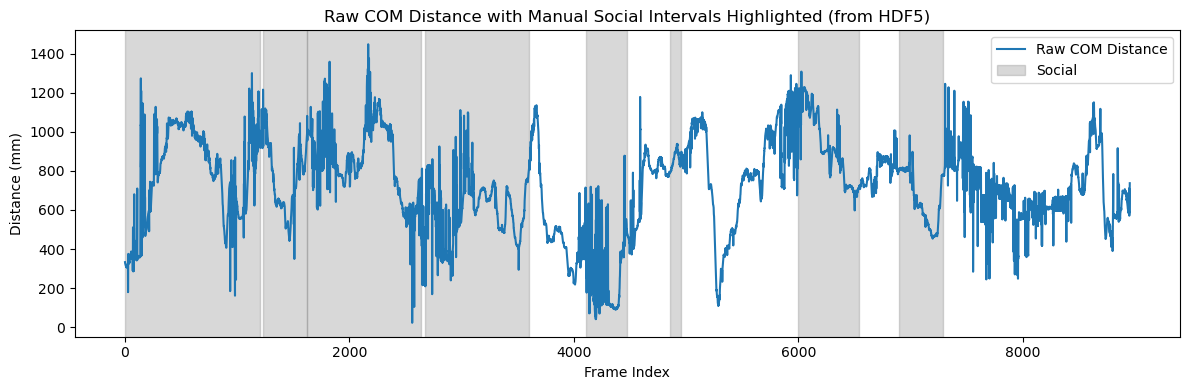


Manual intervals vs baseline distance summary (from HDF5):

   label  start_s  end_s  start_frame  end_frame  mean_dist  median_dist   min_dist    max_dist   std_dist  n_frames
social_1      0.0   40.0          0.0     1200.0 785.720181   836.696436 161.277255 1300.709918 241.127400      1200
social_2     41.0   54.0       1230.0     1620.0 753.396896   717.470207 349.357644 1216.148534 170.445796       390
social_3     54.0   88.0       1620.0     2640.0 857.661879   852.380571  22.526629 1448.403785 186.321572      1020
social_4     89.0  120.0       2670.0     3600.0 602.876089   614.281189 169.012293 1111.489650 154.231316       930
social_5    137.0  149.0       4110.0     4470.0 290.432702   223.828674  40.849098  877.952040 196.436275       360
social_6    162.0  165.0       4860.0     4950.0 864.734353   864.539933 794.638006  938.602288  41.463074        90
social_7    200.0  218.0       6000.0     6540.0 927.698588   898.789009 597.724839 1308.453239 176.764285       540
soc

In [14]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加 session_path。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    # 如果索引是 timestamp_ms_mini，把它重置为普通列
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    df['session_path'] = rec_path
    return df

def plot_raw_com_with_manual_intervals_h5(
    rec_path,
    manual_ranges_s=None,
    fps=30,
    save_csv=True
):
    """
    从 HDF5 文件中载入两只动物的 COM (x, y, z) 数据，
    计算两者每帧的欧式距离，并在同一张图上以灰色高亮手动标注的“社交区间”（秒）。
    同时输出每个标注区间和 baseline（未标注区间）的距离统计指标。

    参数
    ----
    rec_path : str
      会话根文件夹，需包含 MIR_Aligned/*.h5。
    manual_ranges_s : List[Tuple[float,float]]
      手动标注的区间列表，单位是秒。示例：
        [(0.0, 40.0), (41.0, 54.0), (54.0, 88.0), ...]
    fps : int, default 30
      视频/COM 数据的帧率，用它把秒数转换成帧索引。
    save_csv : bool, default True
      是否将统计结果保存为 CSV（路径："{rec_path}/vis/com_manual_summary_h5.csv"）。

    返回
    ----
    pd.DataFrame
      每个手动区间和 baseline 的距离统计：
      - label: "social_i" 或 "baseline"
      - start_s, end_s (秒；baseline 为 NaN)
      - start_frame, end_frame（帧索引）
      - mean_dist, median_dist, min_dist, max_dist, std_dist, n_frames
    """
    # 1. 从 HDF5 加载 DataFrame
    df = load_session_data(rec_path)

    # 2. 提取 COM 坐标列，假设存在列名 'com0_x','com0_y','com0_z','com1_x','com1_y','com1_z'。
    #    如果列名不同，请根据实际情况修改下面的列表。
    com_cols = {
        0:('com2_x', 'com2_y', 'com2_z'),
        1: ('com1_x', 'com1_y', 'com1_z')
    }
    # 检查列是否存在
    for idx, (cx, cy, cz) in com_cols.items():
        if cx not in df.columns or cy not in df.columns or cz not in df.columns:
            raise KeyError(f"DataFrame 中缺少 COM 列: {cx}, {cy} 或 {cz}")

    # 3. 构建 (n_frames, 3, n_animals) 的 numpy 数组
    n_frames = len(df)
    n_animals = len(com_cols)
    com_data = np.zeros((n_frames, 3, n_animals), dtype=float)
    for idx, (cx, cy, cz) in com_cols.items():
        com_data[:, 0, idx] = df[cx].values
        com_data[:, 1, idx] = df[cy].values
        com_data[:, 2, idx] = df[cz].values

    # 4. 计算每帧的欧式距离
    a0 = com_data[:, :, 0]  # (n_frames, 3)
    a1 = com_data[:, :, 1]
    dists = np.linalg.norm(a0 - a1, axis=1)  # (n_frames,)

    # 5. 把手动区间 (秒) → 帧区间
    manual_ranges_s = manual_ranges_s or []
    manual_ranges_frames = []
    for (start_s, end_s) in manual_ranges_s:
        start_f = int(round(start_s * fps))
        end_f   = int(round(end_s   * fps))
        # 限制在 [0, n_frames]
        start_f = max(0, min(start_f, n_frames))
        end_f   = max(0, min(end_f,   n_frames))
        if start_f >= end_f:
            continue
        manual_ranges_frames.append((start_s, end_s, start_f, end_f))

    # 6. 绘图：距离曲线 + 高亮手动区间
    frames = np.arange(n_frames)
    plt.figure(figsize=(12, 4))
    plt.plot(frames, dists, color='tab:blue', label='Raw COM Distance')
    for idx, (start_s, end_s, start_f, end_f) in enumerate(manual_ranges_frames):
        label = 'Social' if idx == 0 else None
        plt.axvspan(start_f, end_f, color='tab:gray', alpha=0.3, label=label)
    plt.xlabel("Frame Index")
    plt.ylabel("Distance (mm)")
    plt.title("Raw COM Distance with Manual Social Intervals Highlighted (from HDF5)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 7. 分段统计：每个手动区间和 baseline
    mask_all = np.zeros(n_frames, dtype=bool)
    summary_list = []

    # 手动区间
    for idx, (start_s, end_s, start_f, end_f) in enumerate(manual_ranges_frames):
        seg = dists[start_f:end_f]
        mask_all[start_f:end_f] = True
        summary_list.append({
            'label':       f"social_{idx+1}",
            'start_s':     start_s,
            'end_s':       end_s,
            'start_frame': start_f,
            'end_frame':   end_f,
            'mean_dist':   np.nanmean(seg),
            'median_dist': np.nanmedian(seg),
            'min_dist':    np.nanmin(seg),
            'max_dist':    np.nanmax(seg),
            'std_dist':    np.nanstd(seg),
            'n_frames':    seg.size
        })

    # baseline 区间（未标注部分）
    base_seg = dists[~mask_all]
    summary_list.append({
        'label':       'baseline',
        'start_s':     np.nan,
        'end_s':       np.nan,
        'start_frame': np.nan,
        'end_frame':   np.nan,
        'mean_dist':   np.nanmean(base_seg) if base_seg.size else np.nan,
        'median_dist': np.nanmedian(base_seg) if base_seg.size else np.nan,
        'min_dist':    np.nanmin(base_seg) if base_seg.size else np.nan,
        'max_dist':    np.nanmax(base_seg) if base_seg.size else np.nan,
        'std_dist':    np.nanstd(base_seg) if base_seg.size else np.nan,
        'n_frames':    base_seg.size
    })

    df_summary = pd.DataFrame(summary_list)
    print("\nManual intervals vs baseline distance summary (from HDF5):\n")
    print(df_summary.to_string(index=False))

    # 8. 保存 CSV
    if save_csv:
        vis_dir = os.path.join(rec_path, 'vis')
        os.makedirs(vis_dir, exist_ok=True)
        csv_path = os.path.join(vis_dir, 'com_manual_summary_h5.csv')
        df_summary.to_csv(csv_path, index=False)
        print(f"\n已将结果保存到：{csv_path}")

    return df_summary

# ========== 示例调用 ==========
if __name__ == '__main__':
    session_folder = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/"
    manual_ranges_s = [
        (0.0, 40.0),   (41.0, 54.0),  (54.0, 88.0),
        (89.0, 120.0), (137.0, 149.0), (162.0, 165.0),
        (200.0, 218.0), (230.0, 243.0), (337.0, 343.0),
        (371.0, 375.0), (466.0, 468.0), (468.0, 472.0),
        (530.0, 530.0), (533.0, 540.0), (562.0, 572.0),
        (573.0, 576.0), (615.0, 617.0), (670.0, 671.0),
    ]
    df_summary = plot_raw_com_with_manual_intervals_h5(
        rec_path=session_folder,
        manual_ranges_s=manual_ranges_s,
        fps=30,
        # save_csv=True
    )


In [16]:
import os
import numpy as np
import scipy.io as sio
import pandas as pd

def save_com_distances(base_folder, com_folder_name='COM/predict00'):
    """
    从 base_folder/{com_folder_name}/com3d0.mat 读取 COM 数据，
    计算每帧两只动物的欧式距离，并将结果保存到 CSV（frame, distance）。

    参数
    ----
    base_folder : str
      会话根文件夹，需包含 "{com_folder_name}/com3d0.mat"。
    com_folder_name : str, default 'COM/predict00'
      相对于 base_folder 的 COM 文件子文件夹名。

    效果
    ----
    在 base_folder/{com_folder_name}/ 下生成 com_distances.csv，
    包含两列：frame（帧索引），distance（该帧的欧式距离）。
    """
    com_mat_path = os.path.join(base_folder, com_folder_name, 'com3d0.mat')
    if not os.path.isfile(com_mat_path):
        raise FileNotFoundError(f"未找到 COM 文件: {com_mat_path}")

    mat = sio.loadmat(com_mat_path)
    if 'com' not in mat:
        raise KeyError(f"'com' 未在 {com_mat_path} 中找到")
    raw = mat['com']

    # reshape to (n_frames, 3, n_animals)
    if raw.ndim == 3 and raw.shape[1] == 3:
        com_data = raw
    elif raw.ndim == 2 and raw.shape[1] % 3 == 0:
        n_animals = raw.shape[1] // 3
        com_data = raw.reshape(-1, 3, n_animals)
    else:
        raise ValueError(f"Unexpected COM shape {raw.shape}")
    n_frames, _, n_animals = com_data.shape
    if n_animals < 2:
        raise ValueError("至少需要两只动物才能计算距离")

    # 计算每帧的欧式距离
    a0 = com_data[:, :, 0]
    a1 = com_data[:, :, 1]
    dists = np.linalg.norm(a0 - a1, axis=1)

    # 构造 DataFrame：frame 和 distance
    df = pd.DataFrame({
        'frame':    np.arange(n_frames),
        'distance': dists
    })

    # 保存 CSV
    output_dir = os.path.join(base_folder, com_folder_name)
    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, 'com_distances.csv')
    df.to_csv(csv_path, index=False)
    print(f"已将 COM 距离保存到：{csv_path}")

    return df

session_paths = [
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1"
    ]


for ss in session_paths:
    save_com_distances(base_folder=ss)

# # ========== 示例调用 ==========
# if __name__ == '__main__':
#     session_folder = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/"  # 替换为实际路径
#     save_com_distances(base_folder=session_folder)


已将 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30/COM/predict00/com_distances.csv
已将 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/COM/predict00/com_distances.csv
已将 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04/COM/predict00/com_distances.csv
已将 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50/COM/predict00/com_distances.csv
已将 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/COM/predict00/com_distances.csv
已将 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/COM/predict00/com_distances.csv
已将 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/COM/predict00/com_distances.csv
已将 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/2

In [18]:
import os
import json
import pandas as pd

def filter_com_by_mapped_frames(
    base_folder,
    com_folder_name='COM/predict00',
    aligned_folder_name='MIR_Aligned',
    frame_mapping_filename='frame_mapping.json',
    output_filename='com_distances_filtered.csv'
):
    """
    从 base_folder/{com_folder_name}/com_distances.csv 读取全部帧的 COM 距离，
    然后根据 base_folder/{aligned_folder_name}/{frame_mapping_filename} 中的
    "mapped_sixcam_frame_indices" 列表，只保留这些帧对应的距离，
    并将结果保存到 base_folder/{aligned_folder_name}/{output_filename}。

    参数
    ----
    base_folder : str
      会话根文件夹路径。
    com_folder_name : str, default 'COM/predict00'
      COM 数据所在子文件夹名，即之前保存 com_distances.csv 的位置。
    aligned_folder_name : str, default 'MIR_Aligned'
      包含 frame_mapping.json 的文件夹名。
    frame_mapping_filename : str, default 'frame_mapping.json'
      存放过滤帧索引的 JSON 文件名，内部需包含键 "mapped_sixcam_frame_indices"。
    output_filename : str, default 'com_distances_filtered.csv'
      过滤后保存结果的文件名。

    返回
    ----
    pd.DataFrame
      仅包含映射帧和对应距离的 DataFrame。
    """
    # 构建 com_distances.csv 的完整路径
    com_csv_path = os.path.join(base_folder, com_folder_name, 'com_distances.csv')
    if not os.path.isfile(com_csv_path):
        raise FileNotFoundError(f"未找到 COM 距离文件: {com_csv_path}")

    # 构建 frame_mapping.json 的完整路径
    mapping_json_path = os.path.join(base_folder, aligned_folder_name, frame_mapping_filename)
    if not os.path.isfile(mapping_json_path):
        raise FileNotFoundError(f"未找到帧映射文件: {mapping_json_path}")

    # 1. 读取 COM 距离 CSV
    df_com = pd.read_csv(com_csv_path)
    if 'frame' not in df_com.columns or 'distance' not in df_com.columns:
        raise KeyError(f"{com_csv_path} 中必须包含 'frame' 与 'distance' 列")

    # 2. 读取 JSON 并提取映射帧索引列表
    with open(mapping_json_path, 'r') as f:
        mapping_data = json.load(f)

    if 'mapped_sixcam_frame_indices' not in mapping_data:
        raise KeyError(f"JSON 文件中缺少键 'mapped_sixcam_frame_indices'")

    mapped_frames = mapping_data['mapped_sixcam_frame_indices']
    if not isinstance(mapped_frames, list):
        raise ValueError(f"'mapped_sixcam_frame_indices' 应为列表")

    # 3. 过滤 DataFrame，只保留 frame 在 mapped_frames 中的行
    df_filtered = df_com[df_com['frame'].isin(mapped_frames)].copy()

    # 4. 确保输出目录存在
    output_dir = os.path.join(base_folder, aligned_folder_name)
    os.makedirs(output_dir, exist_ok=True)

    # 5. 保存过滤后的 CSV
    output_path = os.path.join(output_dir, output_filename)
    df_filtered.to_csv(output_path, index=False)
    print(f"已将过滤后的 COM 距离保存到：{output_path}")

    return df_filtered
for ss in session_paths:
    filter_com_by_mapped_frames(base_folder=ss)
# # ========== 示例调用 ==========
# if __name__ == '__main__':
#     session_folder = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/"  # 替换为实际路径
#     df_result = filter_com_by_mapped_frames(base_folder=session_folder)


已将过滤后的 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30/MIR_Aligned/com_distances_filtered.csv
已将过滤后的 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/MIR_Aligned/com_distances_filtered.csv
已将过滤后的 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04/MIR_Aligned/com_distances_filtered.csv
已将过滤后的 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50/MIR_Aligned/com_distances_filtered.csv
已将过滤后的 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/MIR_Aligned/com_distances_filtered.csv
已将过滤后的 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/MIR_Aligned/com_distances_filtered.csv
已将过滤后的 COM 距离保存到：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/MIR_Aligned/com_distan